<a href="https://colab.research.google.com/github/neelkanthrawat/QBM_sept2022/blob/neel_kl/qmcmc_codes/mcmc_cl_and_quant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import Counter

In [2]:
!pip install qiskit ipywidgets # while working on google colab!

     |████████████████████████████████| 19.2 MB 8.5 MB/s 
     |████████████████████████████████| 240 kB 11.2 MB/s 
     |████████████████████████████████| 106 kB 46.8 MB/s 
     |████████████████████████████████| 55 kB 1.9 MB/s 
     |████████████████████████████████| 943 kB 40.5 MB/s 
     |████████████████████████████████| 37.5 MB 1.5 MB/s 
     |████████████████████████████████| 49 kB 1.9 MB/s 
     |████████████████████████████████| 50 kB 451 kB/s 
     |████████████████████████████████| 4.1 MB 9.3 MB/s 
     |████████████████████████████████| 1.9 MB 40.5 MB/s 
     |████████████████████████████████| 112 kB 45.3 MB/s 
     |████████████████████████████████| 1.6 MB 42.8 MB/s 
  Created wheel for qiskit: filename=qiskit-0.39.2-py3-none-any.whl size=12224 sha256=ee49c07b05f26897fef4754afade5c283ab621bbca4ccc6a1191ad35ea48c68a
  Stored in directory: /root/.cache/pip/wheels/30/dc/90/0ee55ccffd13c16db1abd4c43028f7c9cedb5576b190402190
Successfully built qiskit


In [3]:
!wget https://raw.githubusercontent.com/neelkanthrawat/QBM_sept2022/neel_kl/qmcmc_codes/qbm_utils_2.py

--2022-11-25 16:01:25--  https://raw.githubusercontent.com/neelkanthrawat/QBM_sept2022/neel_kl/qmcmc_codes/qbm_utils_2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30744 (30K) [text/plain]
Saving to: ‘qbm_utils_2.py’

qbm_utils_2.py      100%[===================>]  30.02K  --.-KB/s    in 0.001s  

2022-11-25 16:01:25 (26.2 MB/s) - ‘qbm_utils_2.py’ saved [30744/30744]



In [4]:
from qbm_utils_2 import *

# Define the model

In [5]:
# define the model
np.random.seed(6)# should always be in the same cell!  
n_spins = 10

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

# defining J matrix (mutual 1-1 interaction)
J =  np.round(np.random.randn(n_spins,n_spins), decimals=2)#np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )
J = 0.5 * (J + J.transpose() )
# print("J before:"); print(J)
J= J - np.diag(np.diag(J))

# J=np.array([[0,1,0.5,-1],[1,0,0.3,0.5],[0.5,0.3,0,1],[-1,0.5,1,0]])
print("J after:", J)

# defining h
h = np.round(np.random.randn(n_spins), decimals=2)#np.random.uniform(low= -1, high = 1, size= (n_spins))
# h=np.array([0.5]*n_spins)
print("h is:", h)

# instantiate the model
model = IsingEnergyFunction(J, h)
# print(model.get_energy('0100'))
alpha = np.sqrt(n_spins) / np.sqrt( sum([J[i][j]**2 for i in range(n_spins) for j in range(i)]) + sum([h[j]**2 for j in range(n_spins)])  )
print("alpha: ", alpha)

J after: [[ 0.     1.68   0.285 -0.745 -0.55   0.635  0.78  -0.28   0.91   0.045]
 [ 1.68   0.     0.735 -0.12  -0.205  0.6   -0.34   0.14   0.86   0.11 ]
 [ 0.285  0.735  0.     0.2    0.02  -0.78   0.7    1.09  -1.155  0.025]
 [-0.745 -0.12   0.2    0.     0.535  0.19  -0.7    0.46   0.14   0.17 ]
 [-0.55  -0.205  0.02   0.535  0.    -0.92   0.83  -0.255 -0.55   0.435]
 [ 0.635  0.6   -0.78   0.19  -0.92   0.     0.32  -0.62   0.66   0.815]
 [ 0.78  -0.34   0.7   -0.7    0.83   0.32   0.    -0.53  -0.98   0.075]
 [-0.28   0.14   1.09   0.46  -0.255 -0.62  -0.53   0.    -0.54   0.785]
 [ 0.91   0.86  -1.155  0.14  -0.55   0.66  -0.98  -0.54   0.    -0.355]
 [ 0.045  0.11   0.025  0.17   0.435  0.815  0.075  0.785 -0.355  0.   ]]
h is: [-0.97  0.17  0.12 -0.68 -1.91 -0.14  0.11 -0.4  -0.95 -1.07]
alpha:  0.6255858446578941


### Get the true distribution

In [6]:
def true_boltzman_distn(n_spins:int, temp:int, model, wanna_plot=False):

    states_nbit=states(num_spins=n_spins)# arranged in ascending order in magnitude
    # Actual_probability distribution
    transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state, beta=1./temp) ) for state in states_nbit ] )
    rqd_sum=np.sum(np.array(list(transits_bltz.values())))
    prob_vals=list(np.array(list(transits_bltz.values()))*(1./rqd_sum))
    ### unsorted prob distribution
    bpd=dict(zip(states_nbit, prob_vals ))### dict of distn, arranged in ascending order of keys
    ### Prob distribution, sorted in descending order of prob values
    boltz_prob_distn_sorted_desc=value_sorted_dict( bpd, reverse=True )
    # plot distribution
    if wanna_plot:
        plt.figure(2)
    plot_bargraph_desc_order(boltz_prob_distn_sorted_desc, label="analytical",plot_first_few=30); plt.legend()
    
    return boltz_prob_distn_sorted_desc, bpd

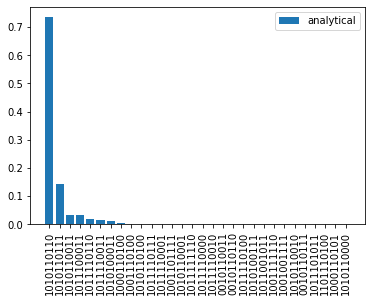

In [7]:
states_nbit=states(num_spins=n_spins)
temp=0.4
boltz_prob_distn,bpd=true_boltzman_distn(n_spins, temp=temp, model=model, wanna_plot=True)#dict sorted in vals,dict sorted in keys
# plot_histogram([bpd], legend=["analytical"])

In [8]:
def get_truncated_distribution(distr: dict, epsilon:float = 0.00001):
    
    return_dict = {}
    index_probable_elements = [ indx for indx, b in enumerate( np.array(list(distr.values())) > epsilon ) if b ]
    states = list(distr.keys())
    probs = list(distr.values())

    for indx in index_probable_elements:
        return_dict[states[indx]] = probs[indx]
    
    return return_dict

In [9]:
mag_all_states=dict_magnetization_of_all_states(list_all_possible_states=states_nbit)
actual_avg_mag=avg(dict_probabilities=boltz_prob_distn, dict_observable_val_at_states=mag_all_states)
print("actual_avg_mag: ",actual_avg_mag)

actual_avg_mag:  2.311034139137276


### Function to run different number of mcmc chains for a particular problem instance

In [10]:
def run_mcmc_different_chains(num_spins:int, 
N_hops:int,num_seperate_mcmc_chains:int ,model,temp:float, 
return_last_n_states:int,return_both=False, is_quantum_mcmc=False, alpha=None ):

    num_elems=2**(num_spins)
    dict_seperate_chains_states_distn_mcmc={}
    dict_seperate_chains_sprime_mcmc={}
    dict_seperate_chains_accepted_mcmc={}
    dict_seperate_chains_counts_based_on_hamming_dist={}# we can get rid of these things
    dict_seperate_chains_energy_diff_s_and_sprime={}# for plotting histogram
    poss_states=list(range(0,num_elems))
    print(f"Whether running quantum mcmc: {is_quantum_mcmc}")
    for chain_num in tqdm(range(0,num_seperate_mcmc_chains)):
        init_state=np.random.choice(poss_states)
        poss_states.remove(init_state)# to ensure that each mcmc chain starts with a different initial state
        initial_state=f'{init_state:0{num_spins}b}'#f'{np.random.randint(0,num_elems):0{num_spins}b}'
        if is_quantum_mcmc:
            dict_states_mcmc, state_mcmc_after_trsn, state_mcmc_after_accept =quantum_enhanced_mcmc(N_hops, num_spins, 
                                                                                initial_state,
                                                                                num_elems,model, 
                                                                                alpha,return_last_n_states=return_last_n_states,
                                                                                return_both=True, temp=temp)
        else:
            dict_states_mcmc, state_mcmc_after_trsn, state_mcmc_after_accept =classical_mcmc(N_hops, num_spins, 
                                                                                initial_state,
                                                                                num_elems,model, 
                                                                                return_last_n_states=return_last_n_states,
                                                                                return_both=True, temp=temp)                                                                        
        # sorting states in descending order of values(# occurences in mcmc chains)  for keys(states) 
        dict_states_mcmc_sorted_desc=value_sorted_dict(dict_states_mcmc, reverse=True)#dict_states_mcmc# this is where I might have to change things a little bit
        #storing in a dict
        dict_seperate_chains_states_distn_mcmc[chain_num]=dict_states_mcmc_sorted_desc
        dict_seperate_chains_sprime_mcmc[chain_num]=state_mcmc_after_trsn
        dict_seperate_chains_accepted_mcmc[chain_num]=state_mcmc_after_accept
        dict_seperate_chains_energy_diff_s_and_sprime[chain_num]=energy_difference_related_counts(num_spins, state_mcmc_after_trsn, state_mcmc_after_accept, model_in=model)
        dict_seperate_chains_counts_based_on_hamming_dist[chain_num]=hamming_dist_related_counts(num_spins, state_mcmc_after_trsn, state_mcmc_after_accept)

    return dict_seperate_chains_states_distn_mcmc, dict_seperate_chains_sprime_mcmc, dict_seperate_chains_accepted_mcmc, dict_seperate_chains_energy_diff_s_and_sprime,dict_seperate_chains_counts_based_on_hamming_dist


In [11]:
# 10 seperate chains of classical mcmc for the given problem instance
N_hops=1000;num_seperate_mcmc_chains=4; return_last_n_states=N_hops
# later get rid of energy difference and hamming distance dicts.
dict_seperate_chains_states_distn_mcmc, dict_seperate_chains_sprime_mcmc, dict_seperate_chains_accepted_mcmc, dict_seperate_chains_energy_diff_s_and_sprime,dict_seperate_chains_counts_based_on_hamming_dist=run_mcmc_different_chains(n_spins, 
N_hops, num_seperate_mcmc_chains,
model, temp=temp, return_last_n_states=return_last_n_states,
return_both=True )

Whether running quantum mcmc: False


  0%|          | 0/4 [00:00<?, ?it/s]

starting with:  1111010110



 25%|██▌       | 1/4 [00:00<00:00,  6.99it/s]

starting with:  0101011001



 50%|█████     | 2/4 [00:00<00:00,  6.72it/s]

starting with:  0110011000



 75%|███████▌  | 3/4 [00:00<00:00,  4.70it/s]

starting with:  0010100011



100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


In [12]:
import time

In [13]:
# kl divergence
# calculate the kl divergence
from math import log2
from math import sqrt
from numpy import asarray
# def kl_divergence(p:list, q:list):
#     return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)) if p[i]!=0)

def kl_divergence(p:list, q:list):
  p=np.array(p).reshape((len(p)))
  q=np.array(q).reshape((len(q)))
  sum_val=np.sum(np.where(p>10**-6,p*np.log2(p/q),0.))
  #print("sum_val:",sum_val)
  return sum_val


# calculate the js divergence
def js_divergence(dict_p:dict, dict_q:dict):
  p=asarray(list(dict_p.values())); q=asarray(list(dict_q.values()))
  m = 0.5 * (p + q)
  #print("m is:");print(m)
  return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

def running_js_divergence(list_chain_state_accepted:list, actual_boltz_distn:dict):
  num_nhops=len(list_chain_state_accepted)
  list_js_after_each_step=[]
  possible_states=list(actual_boltz_distn.keys())
  time_sec1=[];time_sec2=[]
  num_spins=len(list_chain_state_accepted[0])
  poss_states=states(num_spins=num_spins) 
  for step_num in tqdm(range(100,num_nhops)): ##pafloxy : starting at 100 instead of 0 , neglecting effect of intital states
    start1=time.time() 
    # much faster than previous implementation
    # temp_distn_model=dict(zip(poss_states,[0]*(2**num_spins)))  ##pafloxy
    temp_distn_model=dict(zip(possible_states,[0]*(len(possible_states))))  ##pafloxy
    # print('elems sampl i: ', len(temp_distn_model)) ##pafloxy
    temp_distn_model.update(get_distn(list_chain_state_accepted[50:step_num]))  ##pafloxy : starting from 50, neglecting ieffect of initial states 
    # print('elems sampl f: ', len(temp_distn_model)) ##pafloxy
    end1=time.time()
    # print("start1-end1",end1-start1)
    time_sec1.append(end1-start1)
    #js divergence
    start2=time.time()
    # print('elems dist: ', len(actual_boltz_distn), '  elems sampl: ', len(temp_distn_model))  ##@oafloxy
    js_temp=js_divergence(actual_boltz_distn,temp_distn_model)
    end2=time.time()
    #print("_"*20)
    # print("second step:",end2-start2)
    time_sec2.append(end2-start2)
    list_js_after_each_step.append(js_temp)
    #print("_"*100)
    #print(f"at step={step_num} of MCMC , KL Divergence: {js_temp}")
  return list_js_after_each_step, time_sec1, time_sec2

In [14]:
## truncate distribution to a certain epsilon
bpd_trunc = get_truncated_distribution(bpd, epsilon= 0.000001)

np.sum(list(bpd_trunc.values()))

0.9999888762454291

In [ ]:
# list_running_js=[];time1=[];time2=[]
# for i in range(0,num_seperate_mcmc_chains):# need to make this fast! it running very slowly rn
#   print("chain num. :",i)
#   chain_accepted_state=dict_seperate_chains_accepted_mcmc[i]
#   running_js,time1_temp,time2_temp=running_js_divergence(chain_accepted_state,bpd_trunc)
#   list_running_js.append(running_js)
#   time1.append(time1_temp);time2.append(time2_temp)
#   plt.figure()
#   plt.plot(np.sqrt(running_js))
#   plt.xlabel("mcmc steps")
#   plt.ylabel("J-S Distance")

i: 0


  0%|          | 0/900 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log2
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
100%|██████████| 900/900 [00:00<00:00, 2587.00it/s]


i: 1


  0%|          | 0/900 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log2
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
100%|██████████| 900/900 [00:00<00:00, 2732.75it/s]


i: 2


  0%|          | 0/900 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log2
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
100%|██████████| 900/900 [00:00<00:00, 2759.36it/s]


i: 3


  0%|          | 0/900 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log2
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
100%|██████████| 900/900 [00:00<00:00, 2778.60it/s]


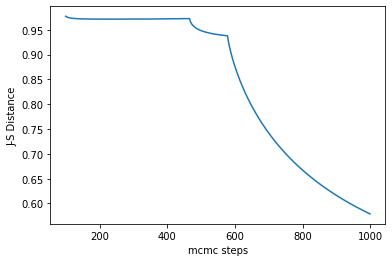

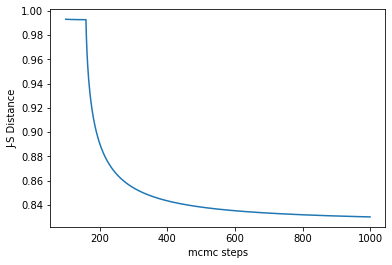

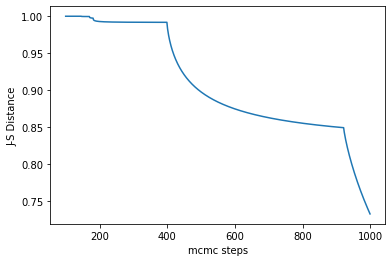

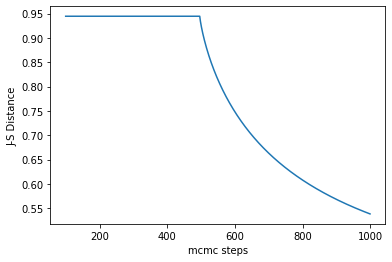

In [17]:
list_running_js=[]
for i in range(0,num_seperate_mcmc_chains):# need to make this fast! it running very slowly rn
  print("i:",i)
  chain_accepted_state=dict_seperate_chains_accepted_mcmc[i]
  running_js,_,_=running_js_divergence(chain_accepted_state,bpd)
  list_running_js.append(running_js)
  plt.figure()
  plt.plot(list(range(100,N_hops)),np.sqrt(running_js))
  plt.xlabel("mcmc steps")
  plt.ylabel("J-S Distance")

In [23]:
def plot_mean_running_avg(list_of_list:list, label:str, start_x_from=0):
  mean_running_val=np.mean(list_of_list,axis=0)
  std=np.std(list_of_list,axis=0)
  plt.fill_between(range(start_x_from,N_hops), mean_running_val+std/2, mean_running_val-std/2, alpha=0.1)
  plt.plot(list(range(start_x_from,N_hops)),mean_running_val,"-",label=label, linewidth=2)

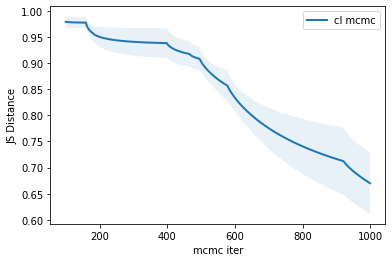

In [24]:
plot_mean_running_avg(np.sqrt(list_running_js),label="cl mcmc",start_x_from=100)
plt.xlabel("mcmc iter");plt.ylabel("JS Distance");plt.legend()

In [25]:
### data for plotting running average magnetization (averaged over "num_seperate_mcmc_chains" number of mcmc chains):
first_few=N_hops# 

list_for_df_running_avg_seperate_mcmc = []
for m in range(0, num_seperate_mcmc_chains):
    list_for_df_running_avg_seperate_mcmc.append(running_avg_magnetization_as_list(dict_seperate_chains_accepted_mcmc[m][:first_few+1]))

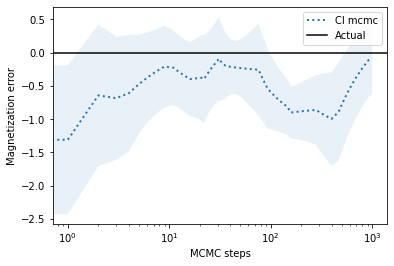

In [26]:
mean_magnetization = np.mean(list_for_df_running_avg_seperate_mcmc, axis=0) - actual_avg_mag
std_magnetization = np.std(list_for_df_running_avg_seperate_mcmc, axis=0)
plt.fill_between(range(len(mean_magnetization)), mean_magnetization+std_magnetization/2, mean_magnetization-std_magnetization/2, alpha=0.1)

plt.plot(mean_magnetization,":" ,label="Cl mcmc", linewidth=2)

plt.axhline(y=0,linestyle="-", color="k" ,label="Actual")
plt.legend()
# plt.ylim(0, 3)
plt.ylabel("Magnetization error")
plt.xlabel("MCMC steps")
plt.xscale("log")
# plt.yscale("log")
# plt.ylim(1e-2, 3)
plt.show()


In [27]:
# pandas data_frame for prob distn obtained from different mcmc chains
def fn_get_dataframe_diff_mcmc_chains_same_problem_instance(dict_seperate_chains_states_mcmc):
    df=pd.DataFrame(dict_seperate_chains_states_mcmc)
    df=df.fillna(0)
    return df

def get_dict_mean_occurences(df_seperate_chains_mcmc_states_occurences):
    mean_occurences=df_seperate_chains_mcmc_states_occurences.mean(axis=1)
    #print("mean occurences:"); print(mean_occurences)
    #print(f"type(mean_occurences): {type(mean_occurences)}")
    dict_mean_occurences=mean_occurences.to_dict()# mean number of occurences; we took mean of data obtained for mcmc chains
    # plt.figure(1); mean_occurences.plot.bar()
    return dict_mean_occurences

def get_empirical_distn(dict_mean_occurences):
    sum_of_counts = sum(dict_mean_occurences.values())
    empirical_probs=list(np.array(list(dict_mean_occurences.values()))/sum_of_counts)
    ### Prob distribution, sorted in descending order of prob values
    dict_empirical_prob_distn=dict(zip(list(dict_mean_occurences.keys()), empirical_probs ))
    return dict_empirical_prob_distn




<Figure size 432x288 with 0 Axes>

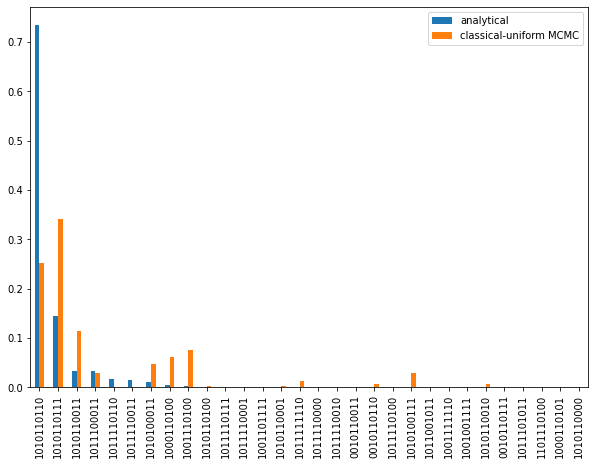

In [28]:
### for classical mcmc
df_1=fn_get_dataframe_diff_mcmc_chains_same_problem_instance(dict_seperate_chains_states_distn_mcmc)
dict_mean_occurences=get_dict_mean_occurences(df_1)
dict_empirical_cl_prob_distn=sort_dict_by_keys(get_empirical_distn(dict_mean_occurences))

plt.figure(1)
plot_multiple_bargraphs(list_of_dicts=[boltz_prob_distn, dict_empirical_cl_prob_distn],
                        list_labels=["analytical","classical-uniform MCMC"],
                        list_normalise=[False,False] ,plot_first_few=30,  
                        sort_desc=True,figsize=(10,7))

In [29]:
np.sqrt(js_divergence(bpd,dict_empirical_cl_prob_distn))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log2
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


0.5015407847121717

### Quantum enhanced MCMC

In [ ]:
# 10 seperate chains of quantum mcmc for the given problem instance
N_hops_q=1000;num_seperate_mcmc_chains_q=4; return_last_n_states_q=N_hops_q
dict_seperate_chains_states_distn_mcmc_q, dict_seperate_chains_sprime_mcmc_q, dict_seperate_chains_accepted_mcmc_q, dict_seperate_chains_energy_diff_s_and_sprime_q,dict_seperate_chains_counts_based_on_hamming_dist_q=run_mcmc_different_chains(n_spins, 
N_hops_q, num_seperate_mcmc_chains_q,
model, temp=temp, return_last_n_states=return_last_n_states_q,
return_both=True, is_quantum_mcmc=True, alpha=alpha )

i: 0


  0%|          | 0/900 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log2
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
100%|██████████| 900/900 [00:00<00:00, 2299.38it/s]


i: 1


  0%|          | 0/900 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log2
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
100%|██████████| 900/900 [00:00<00:00, 2861.24it/s]


i: 2


  0%|          | 0/900 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log2
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
100%|██████████| 900/900 [00:00<00:00, 2821.02it/s]


i: 3


  0%|          | 0/900 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log2
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
100%|██████████| 900/900 [00:00<00:00, 2376.04it/s]


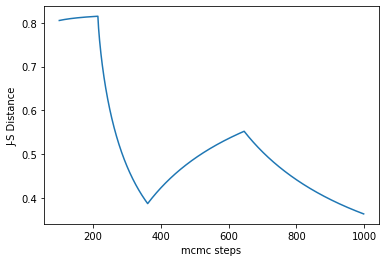

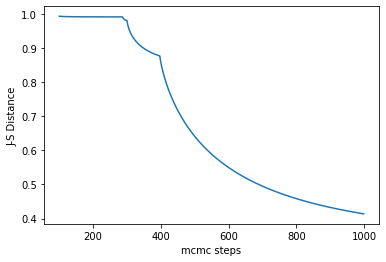

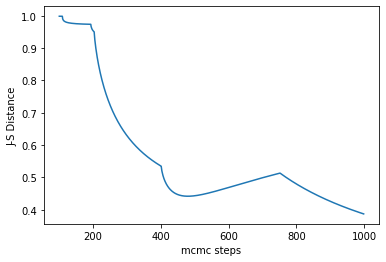

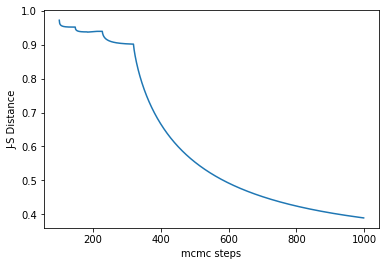

In [32]:
list_running_js_q=[]
for i in range(0,num_seperate_mcmc_chains_q):
  print("i:",i)
  chain_accepted_state_q=dict_seperate_chains_accepted_mcmc_q[i]
  running_js_q,_,_=running_js_divergence(chain_accepted_state_q,bpd)
  list_running_js_q.append(running_js_q)
  plt.figure()
  plt.plot(list(range(100,N_hops)),np.sqrt(running_js_q))
  plt.xlabel("mcmc steps")
  plt.ylabel("J-S Distance")

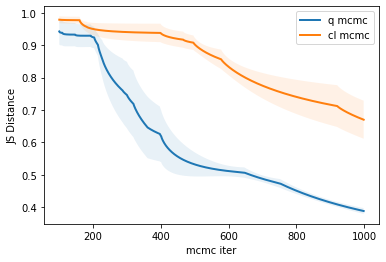

In [33]:
plot_mean_running_avg(np.sqrt(list_running_js_q),label="q mcmc",start_x_from=100)
plot_mean_running_avg(np.sqrt(list_running_js),label="cl mcmc",start_x_from=100)
plt.xlabel("mcmc iter");plt.ylabel("JS Distance");plt.legend()

In [34]:
### data for plotting running average magnetization 5 cases seperately:
first_few=N_hops_q# 
list_for_df_running_avg_seperate_mcmc_q = []
for m in range(0, num_seperate_mcmc_chains_q):
    list_for_df_running_avg_seperate_mcmc_q.append(running_avg_magnetization_as_list(dict_seperate_chains_accepted_mcmc_q[m][:first_few+1]))


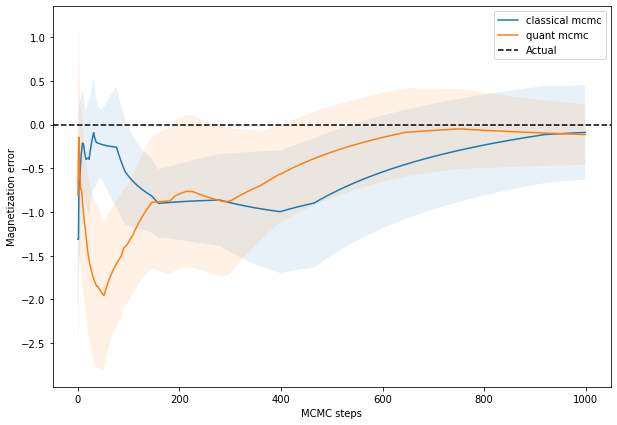

In [35]:
mean_magnetization_q = np.mean(list_for_df_running_avg_seperate_mcmc_q, axis=0) - actual_avg_mag
std_magnetization_q = np.std(list_for_df_running_avg_seperate_mcmc_q, axis=0)

plt.figure(figsize=(10,7))

plt.fill_between(range(len(mean_magnetization)), mean_magnetization+std_magnetization/2, mean_magnetization-std_magnetization/2, alpha=0.1)
plt.fill_between(range(len(mean_magnetization_q)), mean_magnetization_q+std_magnetization_q/2, mean_magnetization_q-std_magnetization_q/2, alpha=0.1)

# magnetization_of_all_states=dict_magnetization_of_all_states(states_nbit)
# actual_avg_mag=avg(dict_probabilities=boltz_prob_distn, dict_observable_val_at_states=magnetization_of_all_states)

plt.plot(mean_magnetization,"-" ,label="classical mcmc")
plt.plot(mean_magnetization_q,"-" ,label="quant mcmc")
plt.axhline(y=0,linestyle="--", color="k" ,label="Actual")
plt.legend()
#plt.ylim(-1, 1)
plt.ylabel("Magnetization error")
plt.xlabel("MCMC steps")
plt.show()

<Figure size 432x288 with 0 Axes>

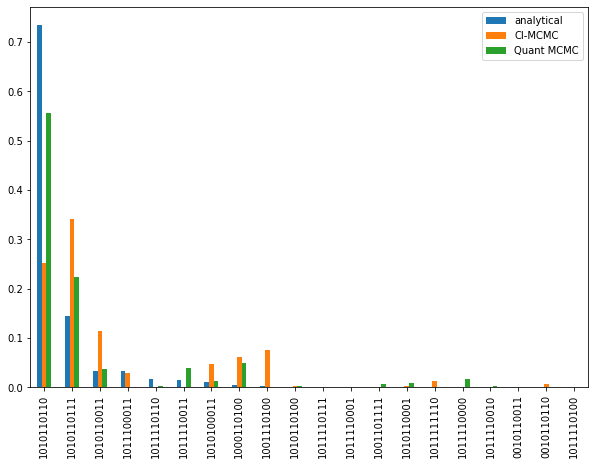

In [36]:
### for quantum mcmc
df_q=fn_get_dataframe_diff_mcmc_chains_same_problem_instance(dict_seperate_chains_states_distn_mcmc_q)
dict_mean_occurences_q=get_dict_mean_occurences(df_q)
dict_empirical_prob_distn_q=sort_dict_by_keys(get_empirical_distn(dict_mean_occurences_q))

plt.figure(1)
plot_multiple_bargraphs(list_of_dicts=[boltz_prob_distn, dict_empirical_cl_prob_distn,dict_empirical_prob_distn_q],
                        list_labels=["analytical","Cl-MCMC","Quant MCMC"],
                        list_normalise=[False,False,False] ,plot_first_few=20,  
                        sort_desc=True,figsize=(10,7))

In [37]:
print("JS distance quantum case:");
print(np.sqrt(js_divergence(dict_empirical_prob_distn_q,bpd)))
print("JS distance classical case:")
print(np.sqrt(js_divergence(dict_empirical_cl_prob_distn,bpd)))

JS distance quantum case:
0.3058534493115944
JS distance classical case:
0.5015407847121717


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log2
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


In [ ]:
# def similarity_coefficient(target_prob_distn:dict, model_prob_distn:dict):
#   """ Returns: Bhattacharya coefficient BC(P,Q)= \sum_{i} sqrt(P(i)*Q(i))
#       Args: target_prob_distn: P
#             model_prob_distn: Q, approximates P
#   """
#   list_prob_model=list(target_prob_distn.values())
#   list_prob_data=list(model_prob_distn.values())
#   list_keys_model=list(model_prob_distn.keys())

#   sim_coeff=0
#   for i in range(0,len(list_keys_model)):
#       if(list_prob_data[i]== 0 or list_prob_model==0):
#           to_return+= 0
#       else:
#         sim_coeff+=np.sqrt(list_prob_data[i]*list_prob_model[i])
#   return sim_coeff

# def running_sim_coeff(list_chain_state_accepted:list,actual_boltz_distn:dict):
#   num_nhops=len(list_chain_state_accepted)
#   list_sim_coeff_after_each_step=[]
#   for step_num in range(1,num_nhops):
#     #print("step_num: ",step_num)
#     temp_distn_model=get_distn(list_chain_state_accepted[:step_num])
#     #print("temp_distribution:")
#     #print(temp_distn_model)
#     sim_coeff_temp=similarity_coefficient(actual_boltz_distn,temp_distn_model)
#     list_sim_coeff_after_each_step.append(sim_coeff_temp)
#     print(f"at step={step_num} of MCMC , bhatt.coeff: {sim_coeff_temp}")
#   return list_sim_coeff_after_each_step